# Difference-in-Differences Event Study Design with variation in treatment timing

Prof. Daniel de Abreu Pereira Uhr

## Conteúdo

* Introdução
* TWFE Event Study
* Gardner (2022)
* Borusyak, Jaravel e Spiess (2024)
* Sun & Abraham (2021)
* de Chaisemartin & D’Haultfoeuille (2020/2022)


## Referências

**Principais:**
* Borusyak, K., Jaravel, X., & Spiess, J. (2024). Revisiting Event Study Designs: Robust and Efficient Estimation. The Review of Economic Studies, Volume 91, Issue 6, November 2024, Pages 3253–3285, https://doi.org/10.1093/restud/rdae007 
* Gardner, J. (2022). "Two-stage differences in differences," Papers 2207.05943, arXiv.org. https://arxiv.org/abs/2207.05943 
* Sun, L., & Abraham, M. (2021). Estimating Dynamic Treatment Effects in Event Studies with Heterogeneous Treatment Effects. Journal of Econometrics, 222(2), 1011-1033. https://doi.org/10.1016/j.jeconom.2020.09.006
* Stevenson, Betsey, Wolfers, Justin, 2006. Bargaining in the shadow of the law: Divorce laws and family distress. Q. J. Econ. 121 (1), 267–288.



**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Introdução

Nesse material temos a aplicação manual dos seguintes estimadores:
* TWFE Event Study
* Gardner (2021)
* Borusyak, Jaravel e Spiess (2023)
* Sun & Abraham (2021)

Vamos dar uma breve comentada na estrutura do estimador, e posteriormente aplicamos "na mão" cada um deles.

Base de dados que utilizaremos para as aplicações

In [71]:
import pandas as pd
# Carregar a base de dados
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/bacon_example.dta")

Filtragem das variáveis

In [72]:
# Resultado/Outcome (Suicide Mortality)
df['Y'] = df['asmrs']
# Treatment D (Staggered treatment adoption)
df['D'] = df['post']
# Covariáveis - pcinc asmrh cases
df['X1'] = df['pcinc']
df['X2'] = df['asmrh']
df['X3'] = df['cases']

# Identificação do painel
df['year'] = df['year'].astype(int)
df['id'] = df['stfips'].astype('category').cat.codes + 1

# Relative time (Tempo relativo até o tratamento - ocorre somente para os tratados)
df['reltime'] = df['year'] - df['_nfd']
# colocar valor zero caso tenha dados faltantes
df['reltime'] = df['reltime'].fillna(0)
# garantir que 'reltime' seja um inteiro
df['reltime'] = df['reltime'].astype(int)

# Generates a new column called 'ct' containing the numerics version of calendar time 'year'
df['ct'] = df['year'] - 1964

# Vamos criar a variável de grupo (cohoort) e G (Callaway-SantAnna)
df['cohort'] = df['_nfd'] - 1965
df['G']=df['_nfd']

# Grupo dos não-tratados (control group)
df['treated'] = 0
df.loc[df['_nfd'] > 0, 'treated'] = 1
df['control_group'] = 1
df.loc[df['treated'] == 1, 'control_group'] = 0

# Criar uma coluna que identifica os indivíduos que nunca foram tratados (nevertreated)
df['nevertreated'] = 0
df.loc[df['treated'] == 0, 'nevertreated'] = 1

# Criar uma coluna que identifica os indivíduos que sempre foram tratados (alwaystreated) 
# Deve ser 1 para todos os anos após o tratamento D
df['mean_treat'] = df.groupby('id')['D'].transform('mean')

# Criar os sempre tratados
df['alwaystreated'] = 0
df.loc[(df['mean_treat'] == 1), 'alwaystreated'] = 1

### TWFE Event Study

Abaixo está um pipeline TWFE “tradicional” com parâmetros no topo para escolher o grupo de controle (all, not_yet, never), o período de referência do event study e (opcionalmente) uma janela de leads/lags

Interpretação dos controles (amostra usada no TWFE):

* all (padrão “TWFE clássico”): usa todos os dados (never + not_yet + pós-tratamento).
* not_yet: exclui os never do painel — controles vêm só dos ainda-não-tratados (entre os ever-treated).
* never: remove os períodos pré-tratamento das unidades ever-treated, mantendo apenas (i) os pós das tratadas e (ii) todos os never. Assim, o contraste é “tratados (pós) vs nunca”.

=== TWFE — ATT médio ===
ATT            : -2.9301
SE (cluster id):  2.4554
p-valor        :  0.2327
IC 95%         : [-7.7426,  1.8823]

=== TWFE — Event Study (padrão mínimo p/ plot) ===
    rel_year  estimate       se  ci_lower  ci_upper
0        -21  -22.5455   4.3698  -31.1100  -13.9809
1        -20  -11.3461  12.5139  -35.8730   13.1807
2        -19    9.3751   5.0760   -0.5737   19.3239
3        -18    0.2236   5.5972  -10.7468   11.1939
4        -17   -3.4972   7.2225  -17.6529   10.6586
5        -16    0.0517   3.7707   -7.3388    7.4422
6        -15    2.0757   3.8679   -5.5052    9.6566
7        -14    5.6494   4.7779   -3.7152   15.0140
8        -13    0.8519   4.0213   -7.0297    8.7335
9        -12    1.2340   6.6797  -11.8580   14.3260
10       -11   -8.0998   3.9510  -15.8437   -0.3559
11       -10   -0.1405   4.8010   -9.5502    9.2692
12        -9   -4.4218   3.4401  -11.1643    2.3206
13        -8   -2.0036   3.7366   -9.3271    5.3200
14        -7   -0.6551   4.2652 

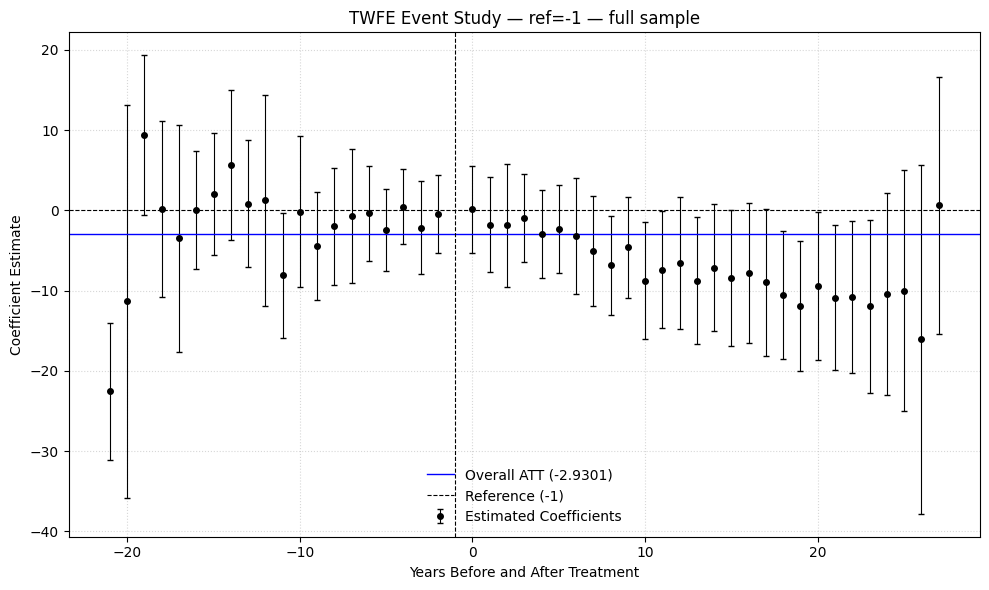

In [75]:
# ============================================================
# TWFE tradicional (ATT + Event Study) — versão ajustada
# Gera twfe_est com colunas: rel_year, estimate, se, ci_lower, ci_upper
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt

# --------- Parâmetros ----------
REF            = -1        # período de referência no event study
WINDOW         = None      # ex.: (-10, 10) para limitar a janela dos leads/lags
ADD_COVS       = "+ X2"        # ex.: "+ X1 + X2 + X3"
INCLUDE_NEVER  = True      # True: usa todos (padrão TWFE); False: usa só ever-treated
SHOW_PLOT      = True

# --------- Preparação ----------
df_twfe = df.copy()

# G (ano de adoção) – usa _nfd se G não existir
if "G" not in df_twfe.columns:
    if "_nfd" in df_twfe.columns:
        df_twfe["G"] = df_twfe["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd'.")

# tipos e variáveis básicas
df_twfe["id"]   = df_twfe["id"].astype("category")
df_twfe["year"] = pd.to_numeric(df_twfe["year"], errors="coerce").astype(int)
df_twfe["G"]    = pd.to_numeric(df_twfe["G"],    errors="coerce").fillna(np.inf)

# indicador de tratamento e tempo relativo (apenas para ever-treated)
ever = np.isfinite(df_twfe["G"].values)
df_twfe["D"]        = (ever & (df_twfe["year"].astype(float) >= df_twfe["G"].values)).astype(int)
df_twfe["rel_year"] = np.where(ever, df_twfe["year"] - df_twfe["G"], np.nan)

# opcional: excluir nunca tratados do TWFE
if not INCLUDE_NEVER:
    df_twfe = df_twfe[ever].copy()

# janela opcional para reduzir categorias extremas no gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df_twfe.loc[(df_twfe["rel_year"] < lo) | (df_twfe["rel_year"] > hi), "rel_year"] = np.nan

# --------- 1) ATT em TWFE (cluster por id) ----------
fml_att = f"Y ~ D + C(id) + C(year) {ADD_COVS}"
y_att, X_att = dmatrices(fml_att, data=df_twfe, return_type="dataframe")
groups_att   = df_twfe.loc[y_att.index, "id"]  # alinhado com o modelo

fit_att = sm.OLS(y_att, X_att).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups_att)[0]}
)

att      = float(fit_att.params.get("D"))
se_att   = float(fit_att.bse.get("D"))
p_att    = float(fit_att.pvalues.get("D"))
ci_lo_att, ci_hi_att = map(float, fit_att.conf_int().loc["D"])

print("=== TWFE — ATT médio ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se_att: .4f}")
print(f"p-valor        : {p_att: .4f}")
print(f"IC 95%         : [{ci_lo_att: .4f}, {ci_hi_att: .4f}]")

# ---------- 2) Event Study em TWFE com dummies manuais ----------

# <<< AJUSTE: criar uma versão inteira segura do tempo relativo (sem round)
df_twfe["rel_year_int"] = pd.to_numeric(df_twfe["rel_year"], errors="coerce").astype("Int64")  # <<< AJUSTE

# referência: se REF não existir nos dados, usa o maior negativo; senão 0
rel_vals = df_twfe.loc[np.isfinite(df_twfe["G"]) & df_twfe["rel_year_int"].notna(), "rel_year_int"].astype(int)
ref_val  = REF if (rel_vals == REF).any() else (max([v for v in rel_vals.unique() if v < 0]) if (rel_vals < 0).any() else 0)

# lista de k (leads/lags) a usar, exceto a referência
ks = sorted(int(k) for k in rel_vals.unique() if k != ref_val)

def safe_name(k: int) -> str:
    return f"es_m{abs(k)}" if k < 0 else f"es_{k}"

# cria dummies de evento só para ever-treated; never tratados ficam 0
es_cols, name2k = [], {}
ever = np.isfinite(df_twfe["G"].values)

for k in ks:
    col = safe_name(k)
    name2k[col] = k
    # <<< AJUSTE: usa igualdade inteira com rel_year_int (sem round)
    df_twfe[col] = ((df_twfe["rel_year_int"] == k) & ever).fillna(False).astype(int)  # <<< AJUSTE
    es_cols.append(col)

# fórmula do event study: dummies + FE + (opcionais) covariáveis
rhs_es = " + ".join(es_cols + ["C(id)", "C(year)"]) + (f" {ADD_COVS}" if ADD_COVS.strip() else "")
fml_es = f"Y ~ {rhs_es}"

# monta matrizes e ajusta (cluster por id)
y_es, X_es = dmatrices(fml_es, data=df_twfe, return_type="dataframe")
groups_es  = df_twfe.loc[y_es.index, "id"]

fit_es = sm.OLS(y_es, X_es).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups_es)[0]}
)

# ---------- 3) DataFrame no padrão mínimo p/ plot conjunto ----------
params = fit_es.params.rename("estimate").to_frame()
bse    = fit_es.bse.rename("se").to_frame()                     # <<< AJUSTE (inclui se)
ci     = fit_es.conf_int(); ci.columns = ["ci_lower","ci_upper"]

est = (
    params.join(bse).join(ci)
           .reset_index().rename(columns={"index":"term"})
)

# mantém apenas as dummies de ES e mapeia o k relativo
est = est[est["term"].isin(es_cols)].copy()
est["rel_year"] = est["term"].map(name2k)
twfe_est = est[["rel_year","estimate","se","ci_lower","ci_upper"]].sort_values("rel_year").reset_index(drop=True)  # <<< AJUSTE

print("\n=== TWFE — Event Study (padrão mínimo p/ plot) ===")
print(twfe_est.round(4))

# ---------- 4) Gráfico (opcional) ----------
if SHOW_PLOT:
    plt.figure(figsize=(10,6))
    yerr = np.vstack([
        twfe_est["estimate"] - twfe_est["ci_lower"],
        twfe_est["ci_upper"] - twfe_est["estimate"]
    ])
    plt.errorbar(
        twfe_est["rel_year"], twfe_est["estimate"],
        yerr=yerr,
        fmt='o', color='black', markersize=4,
        elinewidth=0.8, capsize=2,
        label='Estimated Coefficients'
    )

    # linhas de referência
    plt.axhline(att, color='blue', linestyle='-',  linewidth=1, label=f'Overall ATT ({att:.4f})')
    plt.axhline(0,   color='black', linestyle='--', linewidth=0.8)
    plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8, label=f'Reference ({ref_val})')

    plt.title(f"TWFE Event Study — ref={ref_val}" + (" — ever-treated" if not INCLUDE_NEVER else " — full sample"))
    plt.xlabel("Years Before and After Treatment")
    plt.ylabel("Coefficient Estimate")
    plt.legend(frameon=False, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------
# Saída principal p/ plot:
#   twfe_est  -> DataFrame com:
#       ['rel_year','estimate','se','ci_lower','ci_upper']
# ------------------------


### Gardner (2021)

=== DID2S (Gardner) — ATT médio | controle = not_yet ===
ATT            : -5.8303
SE (cluster id):  2.0060
p-valor        :  0.0037
IC 95%         : [-9.7620, -1.8987]

=== Gardner — Event Study (padrão mínimo p/ plot) ===
    rel_year  estimate       se  ci_lower  ci_upper
0      -21.0  -14.1541   0.0000  -14.1541  -14.1541
1      -20.0   -5.4338  10.1636  -25.3540   14.4863
2      -19.0   14.0382   5.3331    3.5855   24.4908
3      -18.0    4.6039   2.2256    0.2419    8.9660
4      -17.0    0.9572   3.9669   -6.8177    8.7321
5      -16.0    4.1938   0.6746    2.8716    5.5160
6      -15.0    5.2022   3.5014   -1.6604   12.0648
7      -14.0    9.0605   5.0938   -0.9232   19.0442
8      -13.0    1.8302   4.1986   -6.3989   10.0593
9      -12.0    3.1213   4.9941   -6.6669   12.9094
10     -11.0   -5.5715   2.3321  -10.1423   -1.0008
11     -10.0    2.6913   2.6607   -2.5234    7.9061
12      -9.0   -1.8915   1.7198   -5.2624    1.4793
13      -8.0   -0.2944   1.4264   -3.0901    2.50

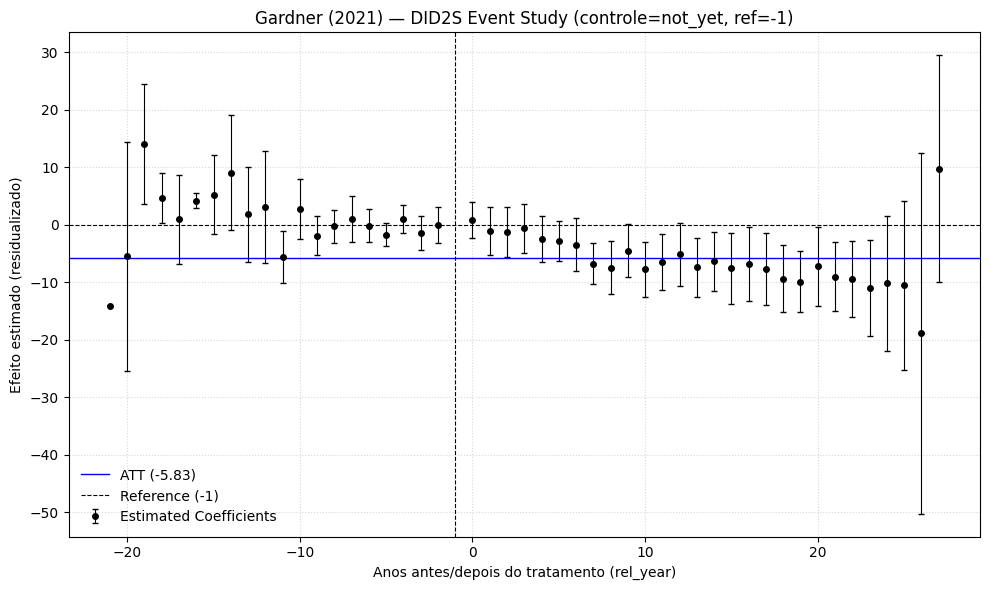

In [76]:
# ============================================================
# Gardner (2021) — DID2S com ES e saída padronizada
# Gera gardner_est: ['rel_year','estimate','se','ci_lower','ci_upper']
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ---------- Parâmetros ----------
CONTROL        = "not_yet"   # "not_yet" (recomendado) ou "never"
REF            = -1          # período de referência do event study
WINDOW         = None        # ex.: (-10, 10) ou None
ADD_COVS       = "+ X2"          # ex.: "+ X1 + X2 + X3"
SHOW_ATT_LINE  = True        # desenhar linha horizontal com ATT médio no gráfico
SHOW_REF_POINT = False       # se True, mantém o coeficiente da referência no gráfico
SHOW_PLOT      = True       # deixa False se só quiser gerar o DataFrame padronizado

# ---------- Preparos ----------
df_g = df.copy()

# Se sua base não tiver 'G' explícito, use '_nfd' como G (ano de primeira adoção)
if "G" not in df_g.columns:
    if "_nfd" in df_g.columns:
        df_g["G"] = df_g["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

# Tipos e coerções
df_g["id"]   = df_g["id"].astype("category")
df_g["year"] = pd.to_numeric(df_g["year"], errors="coerce").astype(int)
df_g["G"]    = pd.to_numeric(df_g["G"],    errors="coerce").fillna(np.inf)

# Tratamento e tempo relativo (para ever-treated)
df_g["D"] = ((np.isfinite(df_g["G"])) & (df_g["year"].astype(float) >= df_g["G"])).astype(int)
df_g["rel_year"] = np.where(np.isfinite(df_g["G"]), df_g["year"] - df_g["G"], np.nan)

# (opcional) limitar janela de leads/lags apenas para o ES/plot
if WINDOW is not None:
    lo, hi = WINDOW
    df_g.loc[(df_g["rel_year"] < lo) | (df_g["rel_year"] > hi), "rel_year"] = np.nan

# ---------- 1ª etapa (FE em id + year) ----------
if CONTROL == "not_yet":
    # clássico Gardner/BJS: usa observações ainda-não-tratadas (D==0)
    sub = df_g[df_g["D"] == 0].copy()
elif CONTROL == "never":
    # usa apenas os nunca tratados (G == +inf)
    sub = df_g[~np.isfinite(df_g["G"])].copy()
else:
    raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

# Fórmula do 1º estágio (com FE) e covariáveis opcionais
fml_stage1 = f"Y ~ C(id) + C(year) {ADD_COVS} - 1"
fit_stage1 = smf.ols(fml_stage1, data=sub).fit()

# Predição contrafactual de FE: Yhat = FE_id + FE_year (+ covs)
df_g["_Yhat_fe"] = fit_stage1.predict(df_g)

# Fallback simples se estiver em CONTROL='never' e faltar algum id no treino
if CONTROL == "never":
    ids_train = set(sub["id"].cat.categories if hasattr(sub["id"], "cat") else sub["id"].unique())
    ids_full  = set(df_g["id"].cat.categories if hasattr(df_g["id"], "cat") else df_g["id"].unique())
    missing_ids = sorted(list(ids_full - ids_train))
    if len(missing_ids) > 0:
        print(f"Aviso: {len(missing_ids)} ids tratados não apareceram no treino (controle='never'). "
              f"Previsões para esses ids usarão somente efeitos de ano (C(year)) + covariáveis.")
        fit_year = smf.ols(f"Y ~ C(year) {ADD_COVS} - 1", data=sub).fit()
        mask_missing = df_g["id"].isin(missing_ids)
        df_g.loc[mask_missing, "_Yhat_fe"] = fit_year.predict(df_g[mask_missing])

# Resíduo “purificado” por FE (primeiro passo Gardner)
df_g["_resid"] = df_g["Y"] - df_g["_Yhat_fe"]

# ---------- 2ª etapa: ATT médio (DID2S) ----------
fit_att = smf.ols("_resid ~ D - 1", data=df_g).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_g["id"]}  # cluster por id
)
att      = float(fit_att.params["D"])
se_att   = float(fit_att.bse["D"])
pval_att = float(fit_att.pvalues["D"])
ci_low_att, ci_high_att = map(float, fit_att.conf_int().loc["D"].tolist())

print(f"=== DID2S (Gardner) — ATT médio | controle = {CONTROL} ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se_att: .4f}")
print(f"p-valor        : {pval_att: .4f}")
print(f"IC 95%         : [{ci_low_att: .4f}, {ci_high_att: .4f}]")

# ---------- 2ª etapa: Event Study (leads/lags) ----------
# Usa apenas ever-treated com rel_year válido
df_es = df_g[df_g["rel_year"].notna()].copy()
df_es["rel_year_int"] = pd.to_numeric(df_es["rel_year"], errors="coerce").astype(int)

# Se REF não existir na amostra, define automaticamente (último negativo, ou 0)
ref_val = REF
if not (df_es["rel_year_int"] == ref_val).any():
    negs = sorted([x for x in df_es["rel_year_int"].unique() if x < 0])
    ref_val = negs[-1] if negs else 0

# Remover NAs que entram no modelo (mantém alinhamento com clusters)
df_es = df_es.dropna(subset=["_resid", "rel_year_int", "id"]).copy()

# ES com referência 'ref_val' e sem intercepto
# (cada coeficiente é o efeito relativo a ref_val)
fml_es = f"_resid ~ C(rel_year_int, Treatment(reference={ref_val})) - 1"
fit_es = smf.ols(fml_es, data=df_es).fit(
    cov_type="cluster", cov_kwds={"groups": df_es["id"]}
)

# ---------- Saída padronizada p/ plot conjunto ----------
# params, se e IC
params = fit_es.params.rename("estimate").to_frame()
bse    = fit_es.bse.rename("se").to_frame()
ci     = fit_es.conf_int(); ci.columns = ["ci_lower", "ci_upper"]

est = (
    params.join(bse).join(ci)
          .reset_index().rename(columns={"index": "term"})
)

# extrair número do rel_year a partir do nome do termo (ex.: 'C(rel_year_int, Treatment(reference=-1))[T.0]')
est["rel_year"] = est["term"].str.extract(r"\[T?\.?(-?\d+)\]")[0].astype(float)

# remove a linha da referência, se solicitado
if not SHOW_REF_POINT:
    est = est[est["rel_year"] != float(ref_val)]

# ordena e seleciona colunas no padrão mínimo
gardner_est = (
    est.dropna(subset=["rel_year"])
       .sort_values("rel_year")
       .loc[:, ["rel_year", "estimate", "se", "ci_lower", "ci_upper"]]
       .reset_index(drop=True)
)

print("\n=== Gardner — Event Study (padrão mínimo p/ plot) ===")
print(gardner_est.round(4))

# ---------- Gráfico (opcional) ----------
if SHOW_PLOT:
    plt.figure(figsize=(10, 6))
    yerr = np.vstack([
        gardner_est["estimate"] - gardner_est["ci_lower"],
        gardner_est["ci_upper"] - gardner_est["estimate"]
    ])
    plt.errorbar(
        gardner_est["rel_year"],
        gardner_est["estimate"],
        yerr=yerr,
        fmt='o',
        color='black',
        markersize=4,
        elinewidth=0.8,
        capsize=2,
        label='Estimated Coefficients'
    )
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    if SHOW_ATT_LINE:
        plt.axhline(att, color='blue', linestyle='-', linewidth=1, label=f'ATT ({att:.2f})')
    plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8, label=f'Reference ({ref_val})')
    plt.title(f'Gardner (2021) — DID2S Event Study (controle={CONTROL}, ref={ref_val})', fontsize=12)
    plt.xlabel('Anos antes/depois do tratamento (rel_year)', fontsize=10)
    plt.ylabel('Efeito estimado (residualizado)', fontsize=10)
    plt.legend(frameon=False, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------
# Saída principal p/ plot:
#   gardner_est -> DataFrame com:
#       ['rel_year','estimate','se','ci_lower','ci_upper']
# ------------------------


### Borusyak, Jaravel e Spiess (2023)

=== BJS (2023) — ATT médio | controle = not_yet ===
ATT            : -5.8303
SE (cluster id):  2.0136
p-valor        :  0.0038
IC 95%         : [-9.7769, -1.8838]

=== BJS — Event Study (padrão mínimo p/ plot) ===
    rel_year  estimate       se  ci_lower  ci_upper
0        -21  -14.1541   0.0000  -14.1541  -14.1541
1        -20   -5.4338  10.1636  -25.3540   14.4863
2        -19   14.0382   5.3331    3.5855   24.4908
3        -18    4.6039   2.2256    0.2419    8.9660
4        -17    0.9572   3.9669   -6.8177    8.7321
5        -16    4.1938   0.6746    2.8716    5.5160
6        -15    5.2022   3.5014   -1.6604   12.0648
7        -14    9.0605   5.0938   -0.9232   19.0442
8        -13    1.8302   4.1986   -6.3989   10.0593
9        -12    3.1213   4.9941   -6.6669   12.9094
10       -11   -5.5715   2.3321  -10.1423   -1.0008
11       -10    2.6913   2.6607   -2.5234    7.9061
12        -9   -1.8915   1.7198   -5.2624    1.4793
13        -8   -0.2944   1.4264   -3.0901    2.5013
14    

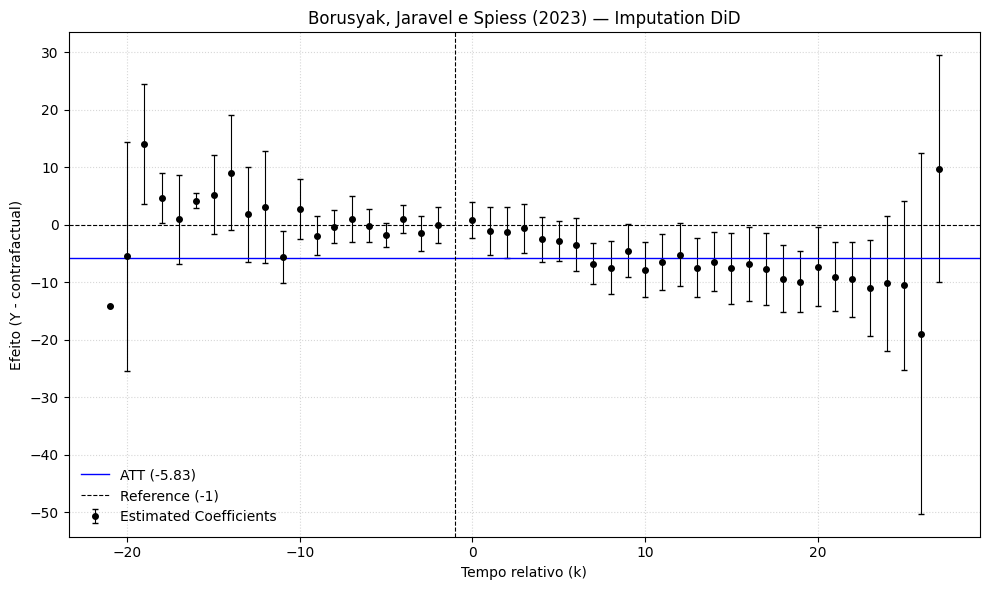

In [77]:
# ============================================================
# BJS (2023) — Imputation DiD (controle: not_yet | never)
# Gera bjs_est: ['rel_year','estimate','se','ci_lower','ci_upper']
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# ---------- Parâmetros ----------
CONTROL         = "not_yet"   # "not_yet" (recomendado) ou "never"
REF             = -1          # período de referência no event study
WINDOW          = None        # ex.: (-10, 10) para limitar janela; ou None
ADD_COVS        = "+ X2"          # ex.: "+ X1 + X2 + X3" no passo 1
SHOW_REF_POINT  = False       # se False, remove o ponto de referência do ES
SHOW_ATT_LINE   = True        # desenhar linha com ATT médio
SHOW_PLOT       = True       # True para ver o gráfico aqui; False se só quiser o DF

# ---------- Preparos ----------
df_b = df.copy()

# G (ano de primeira adoção)
if "G" not in df_b.columns:
    if "_nfd" in df_b.columns:
        df_b["G"] = df_b["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

df_b["id"]   = df_b["id"].astype("category")
df_b["year"] = pd.to_numeric(df_b["year"], errors="coerce").astype(int)
df_b["G"]    = pd.to_numeric(df_b["G"],    errors="coerce").fillna(np.inf)

# Tratamento e tempo relativo
df_b["D"] = ((np.isfinite(df_b["G"])) & (df_b["year"].astype(float) >= df_b["G"])).astype(int)
df_b["rel_year"] = np.where(np.isfinite(df_b["G"]), df_b["year"] - df_b["G"], np.nan)

# (opcional) limitar janela apenas para o ES/plot
if WINDOW is not None:
    lo, hi = WINDOW
    df_b.loc[(df_b["rel_year"] < lo) | (df_b["rel_year"] > hi), "rel_year"] = np.nan

# ---------- Passo 1: modelo contrafactual com controle escolhido ----------
if CONTROL == "not_yet":
    sub = df_b[df_b["D"] == 0].copy()
elif CONTROL == "never":
    sub = df_b[~np.isfinite(df_b["G"])].copy()
else:
    raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

fml_step1 = f"Y ~ C(id) + C(year) {ADD_COVS} - 1"
fit_cf = smf.ols(fml_step1, data=sub).fit()

# Previsão contrafactual
df_b["_Y_cf"] = fit_cf.predict(df_b)

# Fallback se usar 'never' e faltarem ids no treino
if CONTROL == "never":
    ids_train = set(sub["id"].cat.categories if hasattr(sub["id"], "cat") else sub["id"].unique())
    ids_full  = set(df_b["id"].cat.categories if hasattr(df_b["id"], "cat") else df_b["id"].unique())
    missing_ids = sorted(list(ids_full - ids_train))
    if len(missing_ids) > 0:
        print(f"Aviso: {len(missing_ids)} ids tratados não apareceram no treino (controle='never'). "
              f"Previsões para esses ids usarão somente C(year) + covariáveis.")
        fit_year = smf.ols(f"Y ~ C(year) {ADD_COVS} - 1", data=sub).fit()
        mask_missing = df_b["id"].isin(missing_ids)
        df_b.loc[mask_missing, "_Y_cf"] = fit_year.predict(df_b[mask_missing])

# ---------- Tau e ATT (cluster por id) ----------
df_b["_tau"] = df_b["Y"] - df_b["_Y_cf"]

treated = df_b[df_b["D"] == 1].copy()
fit_att = smf.ols("_tau ~ 1", data=treated).fit(
    cov_type="cluster", cov_kwds={"groups": treated["id"]}
)

att      = float(fit_att.params["Intercept"])
se_att   = float(fit_att.bse["Intercept"])
pval_att = float(fit_att.pvalues["Intercept"])
ci_low_att, ci_high_att = map(float, fit_att.conf_int().loc["Intercept"].tolist())

print(f"=== BJS (2023) — ATT médio | controle = {CONTROL} ===")
print(f"ATT            : {att: .4f}")
print(f"SE (cluster id): {se_att: .4f}")
print(f"p-valor        : {pval_att: .4f}")
print(f"IC 95%         : [{ci_low_att: .4f}, {ci_high_att: .4f}]")

# ---------- Event Study (cluster por id) ----------
# usa apenas ever-treated com rel_year válido
df_es = df_b[df_b["rel_year"].notna()].copy()
df_es["rel_year_int"] = pd.to_numeric(df_es["rel_year"], errors="coerce").astype(int)

# referência automática se REF não existir
ref_val = REF
if not (df_es["rel_year_int"] == ref_val).any():
    negs = sorted([x for x in df_es["rel_year_int"].unique() if x < 0])
    ref_val = negs[-1] if negs else 0

# manter alinhamento com clusters
df_es = df_es.dropna(subset=["_tau", "rel_year_int", "id"]).copy()

fml_es = f"_tau ~ C(rel_year_int, Treatment(reference={ref_val})) - 1"
fit_es = smf.ols(fml_es, data=df_es).fit(
    cov_type="cluster", cov_kwds={"groups": df_es["id"]}
)

# ---------- Saída padronizada p/ plot conjunto ----------
params = fit_es.params.rename("estimate").to_frame()
bse    = fit_es.bse.rename("se").to_frame()
ci     = fit_es.conf_int(); ci.columns = ["ci_lower", "ci_upper"]

est = (
    params.join(bse).join(ci)
          .reset_index().rename(columns={"index": "term"})
)

# extrair rel_year dos nomes (aceita '[T.0]' ou '[-1]')
extract_num = est["term"].str.extract(r"\[(?:T\.)?(-?\d+)\]")[0]
est["rel_year"] = pd.to_numeric(extract_num, errors="coerce")

# remover referência do ES se solicitado
if not SHOW_REF_POINT:
    est = est[est["rel_year"] != float(ref_val)]

# DataFrame final no padrão mínimo
bjs_est = (
    est.dropna(subset=["rel_year"])
       .sort_values("rel_year")
       .loc[:, ["rel_year", "estimate", "se", "ci_lower", "ci_upper"]]
       .reset_index(drop=True)
)

print("\n=== BJS — Event Study (padrão mínimo p/ plot) ===")
print(bjs_est.round(4))

# ---------- Gráfico (opcional) ----------
if SHOW_PLOT and not bjs_est.empty:
    plt.figure(figsize=(10, 6))
    yerr = np.vstack([
        bjs_est["estimate"] - bjs_est["ci_lower"],
        bjs_est["ci_upper"] - bjs_est["estimate"]
    ])
    plt.errorbar(
        bjs_est["rel_year"],
        bjs_est["estimate"],
        yerr=yerr,
        fmt='o',
        color='black',
        markersize=4,
        elinewidth=0.8,
        capsize=2,
        label='Estimated Coefficients'
    )
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    if SHOW_ATT_LINE:
        plt.axhline(att, color='blue', linestyle='-', linewidth=1, label=f'ATT ({att:.2f})')
    plt.axvline(ref_val, color='black', linestyle='--', linewidth=0.8, label=f'Reference ({ref_val})')
    plt.title('Borusyak, Jaravel e Spiess (2023) — Imputation DiD', fontsize=12)
    plt.xlabel('Tempo relativo (k)', fontsize=10)
    plt.ylabel('Efeito (Y - contrafactual)', fontsize=10)
    plt.legend(frameon=False, fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------
# Saída principal p/ plot:
#   bjs_est -> DataFrame com:
#       ['rel_year','estimate','se','ci_lower','ci_upper']
# ------------------------


## Sun & Abraham (2021)

Sun e Abraham (2021) propõem um estimador alternativo para estudos de eventos que aborda os problemas de **heterogeneidade nos efeitos do tratamento** em cenários de **adoção escalonada** (*staggered adoption*).  

A proposta surge porque a estratégia tradicional de regressão com **Efeitos Fixos em Dois Níveis** (*Two-Way Fixed Effects – TWFE*), amplamente usada em estudos de evento, gera coeficientes enviesados e de interpretação equivocada quando os efeitos do tratamento são heterogêneos entre coortes ou ao longo do tempo.

### Problema com o TWFE

Em estudos de evento, é comum estimar regressões do tipo:

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{\ell \neq -1} \beta_\ell \cdot 1\{t - E_i = \ell\} + \varepsilon_{it},
$$

onde:
- $\alpha_i$: efeito fixo da unidade,
- $\lambda_t$: efeito fixo do tempo,
- $E_i$: data de início do tratamento da unidade $i$,
- $\ell$: tempo relativo ao tratamento,
- $\beta_\ell$: efeito médio estimado no tempo relativo $\ell$.

**Problema central:**  
- Quando há heterogeneidade nos efeitos do tratamento entre coortes, os coeficientes $\beta_\ell$ deixam de ter interpretação causal clara.  
- Cada $\beta_\ell$ se torna uma **média ponderada complexa** de diferentes efeitos (defasagens e antecipações), podendo até incluir pesos **negativos**.  

Isso gera duas distorções principais:
1. **Contaminação das estimativas**: o coeficiente para uma defasagem pode refletir parcialmente efeitos de outros períodos.
2. **Pré-tendências falsas**: mesmo quando não existem tendências antes do tratamento, a heterogeneidade pode gerar aparentes efeitos espúrios no pré-tratamento.

### A Proposta de Sun & Abraham

O método de Sun & Abraham é um **estimador de estudo de evento limpo**, que se baseia em calcular os efeitos médios do tratamento **específicos por coorte** e depois realizar uma **agregação adequada**.


<div style="text-align:center;">
    <img src="images\SunAbraham1.png"  alt="Imagem" style="width: 700px;"/>
</div>

*Resumo:* Para estimar os efeitos dinâmicos de um tratamento absorvente, os pesquisadores frequentemente utilizam regressões de efeitos fixos em dois níveis (two-way fixed effects) que incluem defasagens e antecipações do tratamento. Demonstramos que, em cenários com variação no momento do tratamento entre as unidades, o coeficiente de uma determinada defasagem ou antecipação pode ser contaminado por efeitos de outros períodos, e aparentes pré-tendências podem surgir exclusivamente devido à heterogeneidade dos efeitos do tratamento. Propomos um estimador alternativo que está livre de contaminação e ilustramos as limitações relativas das regressões de efeitos fixos em dois níveis com defasagens e antecipações por meio de uma aplicação empírica.

#### Passo 1: Definição do CATT (Cohort-ATT)

O parâmetro fundamental é o **Cohort Average Treatment Effect on the Treated (CATT / Cohort-ATT)**:

$$
CATT_{e, \ell} = E \big[ Y_{i, e+\ell}(1) - Y_{i, e+\ell}(0) \,\big|\, E_i = e \big],
$$

onde:
- $e$: coorte (período em que a unidade inicia o tratamento),
- $\ell$: tempo relativo ao tratamento,
- $Y_{i, e+\ell}(1)$: resultado sob tratamento,
- $Y_{i, e+\ell}(0)$: resultado contrafactual sem tratamento.

**Exemplo:**  

Se $e=2$ (tratamento começa no ano 2) e $\ell=1$, o $CATT_{2,1}$ mede o efeito médio **um período após o início do tratamento**, ou seja, no ano 3.

O $CATT_{e,\ell}$ é análogo ao $ATT(g,t)$ de Callaway & Sant’Anna (2021), mas estruturado em termos de tempo relativo, o que facilita a análise dinâmica.


#### Passo 2: Estimação dos CATTs

Cada $CATT_{e,\ell}$ é estimado usando um **grupo de controle apropriado**, composto por unidades que **ainda não foram tratadas** no período $e+\ell$.  
Isso garante que:
- As comparações sejam sempre válidas (não contaminadas por tratados precoces).
- Cada estimativa respeite a lógica de diferenças em diferenças.


#### Passo 3: Agregação via IW (Interaction-Weighted Estimator)

O passo final é agregar os efeitos estimados por coorte em estimadores médios de interesse. O **IW (Interaction-Weighted Estimator)** calcula:

$$
\hat{\theta}_\ell^{IW} = \sum_e w_{e,\ell} \cdot \widehat{CATT}_{e,\ell},
$$

onde:
- $\widehat{CATT}_{e,\ell}$: efeito estimado para coorte $e$ no tempo relativo $\ell$,
- $w_{e,\ell}$: peso proporcional à representatividade da coorte $e$ no período considerado.  

***Como são calculados os pesos no IW?***

os pesos são dados por:

$$
w_{e,\ell} = \frac{N_e}{\sum_{e \in \mathcal{E}_\ell} N_e},
$$

- $N_e$: número de unidades (ou proporção da amostra) na coorte $e$,  
- $\mathcal{E}_\ell$: conjunto das coortes que possuem observações válidas no tempo relativo $\ell$.  

Em outras palavras:  
- Para cada tempo relativo $\ell$, consideramos apenas as coortes que **já foram tratadas** nesse momento.  
- Entre essas coortes, os pesos refletem sua **participação relativa na amostra**.  
- Assim, coortes maiores (mais unidades) têm mais peso na média final.

***Exemplo***

Suponha que temos três coortes de tratamento:
- Coorte $e=2$ com $N_2 = 100$ unidades,
- Coorte $e=3$ com $N_3 = 50$ unidades,
- Coorte $e=4$ com $N_4 = 150$ unidades.

Queremos calcular o efeito médio no tempo relativo $\ell=1$.  
Nesse momento, todas as três coortes já foram tratadas, então:

$$
w_{2,1} = \frac{100}{100+50+150} = 0.25, \quad
w_{3,1} = \frac{50}{300} = 0.17, \quad
w_{4,1} = \frac{150}{300} = 0.50.
$$

Logo:

$$
\hat{\theta}_1^{IW} = 0.25 \cdot \widehat{CATT}_{2,1} \;+\; 
0.17 \cdot \widehat{CATT}_{3,1} \;+\; 
0.50 \cdot \widehat{CATT}_{4,1}.
$$

***É possível calcular o average post-treatment effect***

você pode calcular médias de efeitos em subconjuntos de períodos relativos — por exemplo:
* uma média nos períodos pós-tratamento iniciais (curto prazo),
* uma média em períodos mais distantes (longo prazo),
* ou uma média em todos os períodos pós-tratamento.


### Vantagens do Estimador de Sun & Abraham

1. **Robustez à heterogeneidade:**  
   Os efeitos são sempre definidos em termos de coorte e tempo relativo, evitando contaminação entre períodos.

2. **Interpretação clara:**  
   Cada ponto do gráfico de estudo de evento (pré ou pós) corresponde a um efeito médio com interpretação causal bem definida.

3. **Agregação flexível:**  
   É possível calcular:
   - efeitos dinâmicos ao longo do tempo pós-tratamento ($\ell \geq 0$),
   - testes de pré-tendência com os períodos anteriores ($\ell < 0$),
   - médias em janelas específicas de tempo relativo.

4. **Sem pesos negativos:**  
   Diferentemente do TWFE, os pesos são sempre proporcionais e transparentes.

### Relação com Outros Estimadores

- **Callaway & Sant’Anna (2021):**  
  Baseiam-se no cálculo de $ATT(g,t)$ (efeitos médios por grupo e tempo).  
  - SA pode ser visto como uma **versão dinâmica** desse raciocínio, organizada em tempo relativo.
  
- **Gardner (2022) – DID2S:**  
  Propõe uma implementação eficiente via “duas etapas de regressão” (Two-Stage DiD).  
  - O resultado final é equivalente ao IW de Sun & Abraham, mas a implementação é mais simples em grandes painéis.

- **TWFE tradicional:**  
  Deve ser evitado em presença de heterogeneidade, já que seus coeficientes podem ser médias distorcidas sem interpretação causal.


### Visualização dos Resultados

O produto final do estimador de Sun & Abraham é um **gráfico de estudo de evento limpo**, em que:
- O eixo $x$ mostra o tempo relativo ao tratamento ($\ell$).
- O eixo $y$ mostra os efeitos médios estimados ($\hat{\theta}_\ell^{IW}$).
- Os períodos de pré-tratamento ($\ell<0$) são usados para testar se existem tendências prévias.
- Os períodos pós-tratamento ($\ell\geq0$) mostram a evolução do efeito dinâmico ao longo do tempo.


C:\Users\danie\AppData\Local\Temp\ipykernel_17204\1066293245.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sa[col] = ((g_mask) & (df_sa["rel_year_int"] == k)).astype(int)
C:\Users\danie\AppData\Local\Temp\ipykernel_17204\1066293245.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sa[col] = ((g_mask) & (df_sa["rel_year_int"] == k)).astype(int)
C:\Users\danie\AppData\Local\Temp\ipykernel_17204\1066293245.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

=== Sun & Abraham (2021) — Interaction-Weighted (IW) ===
N (k×coorte) no design: 384

Event-study por k (IW):
    rel_year  estimate       se  ci_lower  ci_upper
0        -21  -14.8565   6.5351  -27.6653   -2.0476
1        -20   -9.6539   5.0269  -19.5066    0.1987
2        -19    8.8898   6.1737   -3.2106   20.9902
3        -18    1.5469   6.2519  -10.7068   13.8007
4        -17   -0.8325   5.7730  -12.1475   10.4826
5        -16    3.8110   5.0053   -5.9994   13.6214
6        -15    5.0376   4.5336   -3.8482   13.9235
7        -14    8.2153   4.3569   -0.3242   16.7547
8        -13    2.3577   8.9943  -15.2712   19.9866
9        -12    0.7346  13.2793  -25.2928   26.7619
10       -11   -6.9569   8.1968  -23.0227    9.1088
11       -10    3.3155   7.2480  -10.8906   17.5215
12        -9   -2.0742   4.3855  -10.6698    6.5214
13        -8   -0.7482   4.8945  -10.3414    8.8450
14        -7   -0.1995   5.4803  -10.9408   10.5418
15        -6   -0.9002   3.8288   -8.4046    6.6041
16    

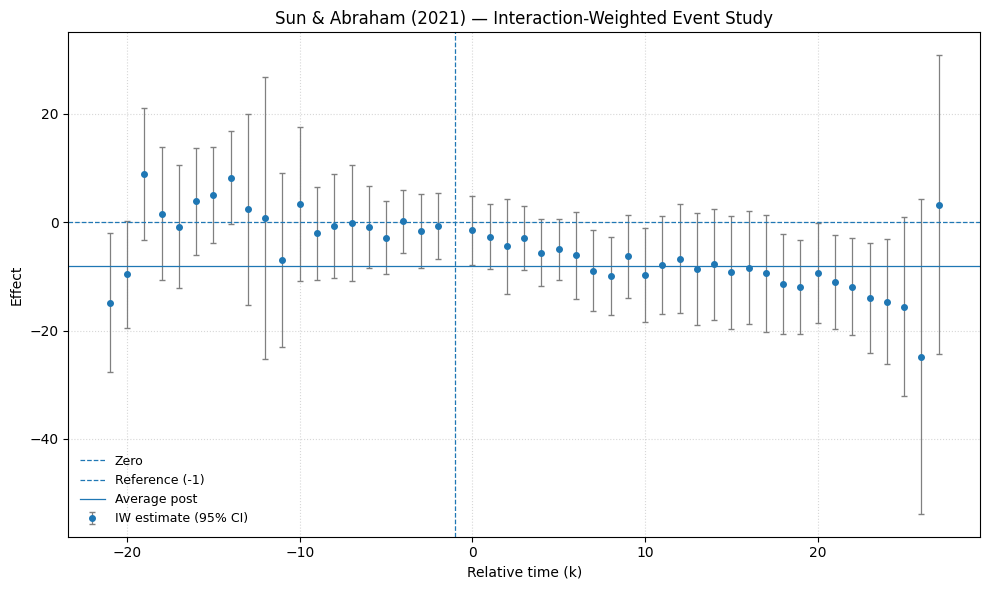

In [78]:
# ============================================================
# Sun & Abraham (2021) — Event-Study por coorte + agregação IW
# Saída padronizada: sa_est = ['rel_year','estimate','se','ci_lower','ci_upper']
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
from scipy import stats

# -------------- Parâmetros do usuário --------------
REF           = -1          # período de referência (lead) omitido no ES
WINDOW        = None        # ex.: (-10, 10) para limpar extremos no gráfico; ou None
ADD_COVS      = "+ X2"          # ex.: "+ X1 + X2 + X3"
SHOW_ATT_LINE = True        # desenhar linha da média pós-tratamento no gráfico
SHOW_PLOT     = True

# -------------- Inputs esperados no df --------------
# df com colunas: 'Y' (outcome), 'id' (unidade), 'year' (tempo), 'G' (coorte) ou '_nfd'

# ============================================================
# PREPARO
# ============================================================
df_sa = df.copy()

# Garantir colunas essenciais
for col in ["Y", "id", "year"]:
    if col not in df_sa.columns:
        raise ValueError(f"Coluna obrigatória ausente: {col}")

# G (ano de 1ª adoção) — se não existir 'G', usa '_nfd'
if "G" not in df_sa.columns:
    if "_nfd" in df_sa.columns:
        df_sa["G"] = df_sa["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd' na base.")

# Tipos e coerções
df_sa["id"]   = df_sa["id"].astype("category")
df_sa["year"] = pd.to_numeric(df_sa["year"], errors="coerce").astype(int)
df_sa["G"]    = pd.to_numeric(df_sa["G"],    errors="coerce")

# ever-treated (G finito) vs nunca tratados (G NaN)
df_sa["treated_ever"] = np.isfinite(df_sa["G"]).astype(int)

# tempo relativo apenas para ever-treated; nunca tratados ficam NaN
df_sa["rel_year"] = np.where(df_sa["treated_ever"] == 1, df_sa["year"] - df_sa["G"], np.nan)
df_sa["rel_year"] = pd.to_numeric(df_sa["rel_year"], errors="coerce")

# (opcional) janela para limpar extremos do gráfico
if WINDOW is not None:
    lo, hi = WINDOW
    df_sa.loc[(df_sa["rel_year"] < lo) | (df_sa["rel_year"] > hi), "rel_year"] = np.nan

# Usaremos uma versão inteira segura do tempo relativo
df_sa["rel_year_int"] = pd.to_numeric(df_sa["rel_year"], errors="coerce").astype("Int64")

# Coortes e suporte de k (antes de construir o design)
cohorts = np.sort(df_sa.loc[df_sa["treated_ever"] == 1, "G"].dropna().unique())
Ks_all = (
    df_sa.loc[(df_sa["treated_ever"] == 1) & (df_sa["rel_year_int"].notna()), "rel_year_int"]
          .astype(int)
          .unique()
)
Ks_all = sorted([int(k) for k in Ks_all])

# Exclui a referência (REF) do conjunto que vira regressor
Ks = [int(k) for k in Ks_all if int(k) != int(REF)]

# Helpers de nomes
def tag_k(k: int) -> str:
    return f"km{abs(k)}" if k < 0 else f"k{k}"

def tag_g(g_val) -> str:
    try:
        return f"g{int(g_val)}"
    except Exception:
        return f"g{g_val}"

# ============================================================
# CONSTRUÇÃO DOS REGRESSORES (dummies k×coorte)
# ============================================================
sa_cols = []          # nomes das colunas dummy criadas
meta = []             # lista de tuplas (colname, k, g) para mapear cada dummy

for g in cohorts:
    g_mask = (df_sa["treated_ever"] == 1) & (df_sa["G"] == g)
    for k in Ks:
        col = f"sa_{tag_k(k)}_{tag_g(g)}"
        # comparação inteira, sem floats
        df_sa[col] = ((g_mask) & (df_sa["rel_year_int"] == k)).astype(int)
        if df_sa[col].sum() > 0:
            sa_cols.append(col)
            meta.append((col, int(k), int(g)))

if len(sa_cols) == 0:
    raise RuntimeError("Nenhum regressor (k×coorte) foi criado. "
                       "Verifique G/rel_year/REF/WINDOW.")

# ============================================================
# REGRESSÃO SA (IW): Y ~ sum_{k≠REF,g} 1{rel_year=k,G=g} + FE_i + FE_t (+ X)
# ============================================================
rhs = " + ".join(sa_cols) + " + C(id) + C(year)" + (f" {ADD_COVS}" if ADD_COVS.strip() else "")
fml = f"Y ~ {rhs}"

# y, X a partir da fórmula; isso define a AMOSTRA EFETIVA
y, X = dmatrices(fml, data=df_sa, return_type="dataframe")

# clusters alinhados às linhas de y (amostra efetiva)
groups = df_sa.loc[y.index, "id"]
fit_sa = sm.OLS(y, X).fit(
    cov_type="cluster",
    cov_kwds={"groups": pd.factorize(groups)[0]}
)

beta = fit_sa.params
V    = fit_sa.cov_params()

# ============================================================
# PESOS (AMOSTRA EFETIVA) E ESTIMATIVAS IW POR k
#   w_{e,k} proporcional ao nº de observações da dummy (coluna do X)
# ============================================================
est_cols = [c for c, _k, _g in meta if c in X.columns]
if len(est_cols) == 0:
    raise RuntimeError("Todas as dummies (k×coorte) foram colineares/descartadas no X.")

# contagem de 1's de cada dummy NA AMOSTRA EFETIVA
counts_design = X[est_cols].sum(axis=0)  # Series: index=colname, value=#1's

# dicionário weights[k][col] = peso normalizado dentro do k
weights = {}
for col, k, g in meta:
    if col not in counts_design.index:
        continue
    w_raw = float(counts_design[col])
    if w_raw > 0:
        weights.setdefault(k, {})
        weights[k][col] = w_raw

# normaliza dentro de cada k
for k in list(weights.keys()):
    s = sum(weights[k].values())
    if s <= 0:
        del weights[k]
        continue
    for col in list(weights[k].keys()):
        weights[k][col] = weights[k][col] / s

# IW por k + ICs
rows = []
for k in sorted(weights.keys()):
    cols_k = list(weights[k].keys())
    if not cols_k:
        continue
    w_vec  = np.array([weights[k][c] for c in cols_k])
    b_vec  = beta.reindex(cols_k).to_numpy()
    V_kk   = V.loc[cols_k, cols_k].to_numpy()

    est_k = float(w_vec @ b_vec)
    var_k = float(w_vec @ V_kk @ w_vec)
    se_k  = float(np.sqrt(max(var_k, 0.0)))
    ci_low, ci_high = est_k - 1.96 * se_k, est_k + 1.96 * se_k

    rows.append({"rel_year": int(k), "estimate": est_k, "se": se_k,
                 "ci_lower": ci_low, "ci_upper": ci_high})

# DataFrame principal para plot conjunto
sa_est = pd.DataFrame(rows).sort_values("rel_year").reset_index(drop=True)

# ============================================================
# "OVERALL POST" (média pós-tratamento) COM IC + t/p
# ============================================================
post_ks = [k for k in weights.keys() if k >= 0]
if len(post_ks) > 0:
    counts_k = {}
    for k in post_ks:
        cols_k = [c for c, kk, _g in meta if (kk == k) and (c in X.columns)]
        counts_k[k] = float(X[cols_k].sum().sum()) if len(cols_k) else 0.0

    denom = sum(counts_k.values())
    if denom > 0:
        a = {k: counts_k[k] / denom for k in counts_k}  # normaliza
        m = pd.Series(0.0, index=beta.index, dtype=float)
        for k in a:
            for col, w in weights[k].items():
                m[col] += a[k] * w

        theta_post = float(m @ beta)
        var_post   = float(m @ V @ m)
        se_post    = float(np.sqrt(max(var_post, 0.0)))
        ci_post    = (theta_post - 1.96*se_post, theta_post + 1.96*se_post)

        t_stat = theta_post / se_post if se_post > 0 else np.nan
        p_val  = 2 * (1 - stats.t.cdf(abs(t_stat), df=float(getattr(fit_sa, 'df_resid', np.inf))))
    else:
        theta_post, se_post, ci_post, t_stat, p_val = np.nan, np.nan, (np.nan, np.nan), np.nan, np.nan
else:
    theta_post, se_post, ci_post, t_stat, p_val = np.nan, np.nan, (np.nan, np.nan), np.nan, np.nan

# ============================================================
# TESTE CONJUNTO DE PRÉ-TENDÊNCIA (leads: k < 0)
# ============================================================
lead_ks = [k for k in sorted(weights.keys()) if k < 0]
if len(lead_ks) > 0:
    R_rows = []
    for k in lead_ks:
        r = pd.Series(0.0, index=beta.index, dtype=float)
        for col, w in weights[k].items():
            r[col] = w
        R_rows.append(r.values)
    R = np.vstack(R_rows)  # matriz de restrições
    wald_res = fit_sa.wald_test(R)
    pretrend_stat = float(np.atleast_1d(wald_res.statistic)[0])
    pretrend_pval = float(np.atleast_1d(wald_res.pvalue)[0])
else:
    pretrend_stat, pretrend_pval = np.nan, np.nan

# ============================================================
# SAÍDAS
# ============================================================
print("=== Sun & Abraham (2021) — Interaction-Weighted (IW) ===")
print(f"N (k×coorte) no design: {len([c for c in sa_cols if c in X.columns])}")
print("\nEvent-study por k (IW):")
print(sa_est.round(4))

if np.isfinite(theta_post):
    print("\nMédia pós-tratamento (overall post):")
    print(f"  Estimativa: {theta_post:.4f}")
    print(f"  SE: {se_post:.4f}")
    print(f"  IC95%: [{ci_post[0]:.4f}, {ci_post[1]:.4f}]")
    print(f"  t-stat: {t_stat:.3f}   p-valor: {p_val:.4f}")

if np.isfinite(pretrend_stat):
    print("\nTeste conjunto de pré-tendência (leads):")
    print(f"  Wald stat: {pretrend_stat:.3f}  p-valor: {pretrend_pval:.4f}")

# ============================================================
# GRÁFICO (opcional)
# ============================================================
if SHOW_PLOT and not sa_est.empty:
    plt.figure(figsize=(10, 6))
    yerr = np.vstack([
        sa_est["estimate"] - sa_est["ci_lower"],
        sa_est["ci_upper"] - sa_est["estimate"]
    ])
    plt.errorbar(
        sa_est["rel_year"],
        sa_est["estimate"],
        yerr=yerr,
        fmt='o',
        markersize=4,
        ecolor='gray',
        elinewidth=0.9,
        capsize=2,
        label='IW estimate (95% CI)'
    )
    plt.axhline(0, linestyle='--', linewidth=0.9, label='Zero')
    plt.axvline(REF, linestyle='--', linewidth=0.9, label=f'Reference ({REF})')
    if SHOW_ATT_LINE and np.isfinite(theta_post):
        plt.axhline(theta_post, linewidth=0.9, label='Average post')
    plt.title('Sun & Abraham (2021) — Interaction-Weighted Event Study', fontsize=12)
    plt.xlabel('Relative time (k)', fontsize=10)
    plt.ylabel('Effect', fontsize=10)
    plt.legend(frameon=False, fontsize=9)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------
# Saída principal p/ plot:
#   sa_est -> DataFrame com:
#       ['rel_year','estimate','se','ci_lower','ci_upper']
# ------------------------


### Comparando os modelos em um mesmo gráfico


Talvez seja conveniente visualizar os resultados dos diferentes estimadores em um mesmo gráfico.

In [79]:
# ============================================================
# Comparador de Event Studies (flexível + "dodge" + opções REF)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_event_studies_custom(
    series,                  # [("twfe_est","TWFE"), ("gardner_est","DID2S"), ...]
    ref=-1,                  # período de referência (linha vertical)
    window=None,             # ex.: (-5,5) para limitar k; None = todos
    save_csv=None,           # caminho CSV combinado (opcional)
    save_png=None,           # caminho PNG do gráfico (opcional)
    title="Event Studies Comparison",
    dodge=0.15,              # deslocamento horizontal entre estimadores
    markers=None,            # lista opcional de marcadores ['o','s','^',...]
    drop_ref_for=None,       # ex.: {'CS'} -> remove rel_year==ref do CS
    center_at_ref_for=None   # ex.: {'CS'} -> recenter: y := y - y(ref)
):
    """
    Cada variável (string) em 'series' deve existir no escopo com colunas:
      ['rel_year','estimate','se','ci_lower','ci_upper'].

    drop_ref_for: conjunto de labels para os quais removemos o ponto em REF.
    center_at_ref_for: conjunto de labels para os quais recentramos a série
                       subtraindo o valor em REF (se existir).
    """
    drop_ref_for = set(drop_ref_for or [])
    center_at_ref_for = set(center_at_ref_for or [])

    # 1) coleta e valida
    dfs, labels = [], []
    for varname, label in series:
        try:
            df_tmp = eval(varname)
        except NameError:
            print(f"[Aviso] variável '{varname}' não está definida; ignorando.")
            continue
        req = {"rel_year","estimate","se","ci_lower","ci_upper"}
        if not isinstance(df_tmp, pd.DataFrame) or df_tmp.empty:
            print(f"[Aviso] '{varname}' vazio/não-DataFrame; ignorando.")
            continue
        if not req.issubset(df_tmp.columns):
            miss = req - set(df_tmp.columns)
            raise ValueError(f"[{label}] faltam colunas: {miss}")

        dt = df_tmp.copy()
        dt["estimator"] = label

        # janela
        if window is not None:
            lo, hi = window
            dt = dt[(dt["rel_year"] >= lo) & (dt["rel_year"] <= hi)]

        # recentrar, se pedido
        if label in center_at_ref_for:
            base = dt.loc[dt["rel_year"] == ref, "estimate"]
            if len(base) == 1:
                dt["estimate"] = dt["estimate"] - float(base.iloc[0])
                dt["ci_lower"] = dt["ci_lower"] - float(base.iloc[0])
                dt["ci_upper"] = dt["ci_upper"] - float(base.iloc[0])
            else:
                print(f"[Aviso] não foi possível recentrar '{label}': não há um único ponto em REF={ref}.")

        # dropar referência, se pedido
        if label in drop_ref_for:
            dt = dt[dt["rel_year"] != ref]

        dfs.append(dt[["estimator","rel_year","estimate","se","ci_lower","ci_upper"]])
        labels.append(label)

    if not dfs:
        print("Nenhuma série válida para plotar.")
        return None

    all_es = pd.concat(dfs, ignore_index=True)

    # salvar CSV
    if save_csv:
        all_es.to_csv(save_csv, index=False)
        print(f"Resultados combinados salvos em {save_csv}")

    # 2) plot com “dodge”
    plt.figure(figsize=(11, 6))
    if markers is None:
        markers = ['o','s','^','D','v','P','X','*','h','>','<']

    ests = list(dict.fromkeys(all_es["estimator"]))
    n = len(ests)
    offsets = [(i - (n-1)/2) * dodge for i in range(n)]

    for i, est_name in enumerate(ests):
        g = all_es[all_es["estimator"] == est_name].sort_values("rel_year")
        if g.empty:
            continue
        x = g["rel_year"].to_numpy(float) + offsets[i]
        y = g["estimate"].to_numpy(float)
        yerr = np.vstack([
            y - g["ci_lower"].to_numpy(float),
            g["ci_upper"].to_numpy(float) - y
        ])
        plt.errorbar(
            x, y,
            yerr=yerr,
            fmt=markers[i % len(markers)],
            markersize=4,
            elinewidth=0.9,
            capsize=2,
            label=est_name
        )

    plt.axhline(0, linestyle='--', linewidth=0.9, color='black')
    plt.axvline(ref, linestyle='--', linewidth=0.9, color='black', label=f"Ref ({ref})")
    plt.title(title, fontsize=12)
    plt.xlabel("Tempo relativo (k)", fontsize=10)
    plt.ylabel("Efeito estimado", fontsize=10)
    plt.legend(frameon=False, fontsize=9)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    if save_png:
        plt.savefig(save_png, dpi=300)
        print(f"Gráfico salvo em {save_png}")
    plt.show()

    return all_es


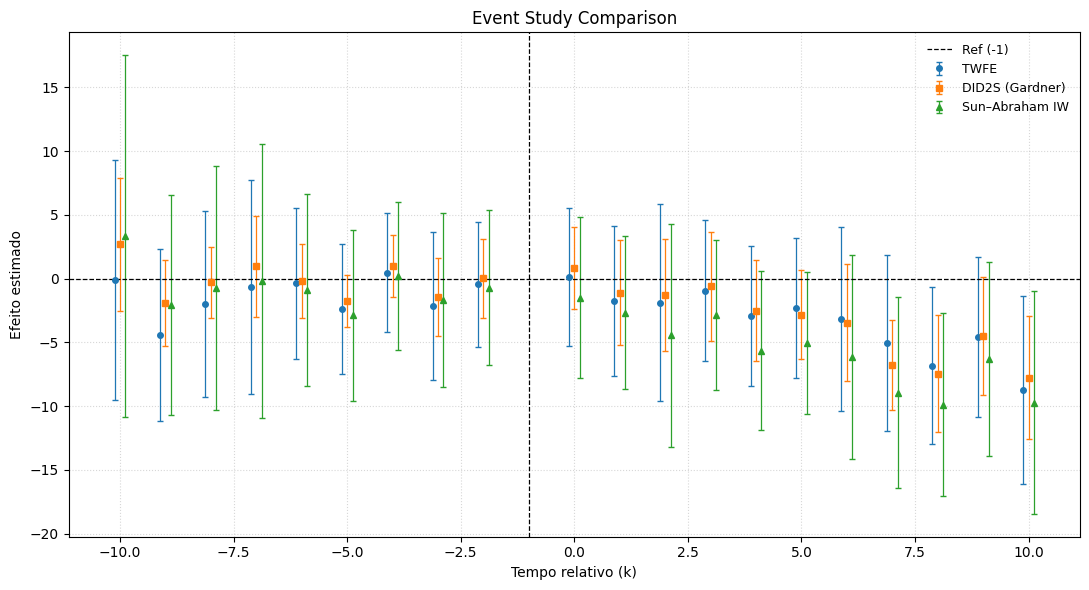

In [80]:
all_es = compare_event_studies_custom(
    series=[
        ("twfe_est",    "TWFE"),
        ("gardner_est", "DID2S (Gardner)"),
        ("sa_est",      "Sun–Abraham IW"),
        #("bjs_est",     "BJS"),
        #("cs_est",      "CS"),
    ],
    ref=-1,
    window=(-10,10),
    title="Event Study Comparison",
    dodge=0.12,
    drop_ref_for={""}        # <- remove o ponto de referência de algum dos estimadores
)


#### Callaway e SantAnna

In [81]:
data = df.copy()
# Filtragem dos dados
# Vamos criar identificadores estaduais
data['id'] = data['stfips'].astype('category').cat.codes + 1

# Outcome (Suicide Mortality)
data['Y'] = data['asmrs']
# Treatment
data['D'] = data['post']
# Covariáveis - pcinc asmrh cases
data['X1'] = data['pcinc']
data['X2'] = data['asmrh']
data['X3'] = data['cases']

# Vamos criar a variável de grupo G
data['G']=data['_nfd']

In [82]:
# Criar uma variável de tempo até o ano do início do tratamento (Tempo em relação ao início do evento)
data['timeToTreat'] = data['year'] - data['_nfd']

In [83]:
# O pacote precisa entender a estrutura de painel dos dados. Precisamos ajustar a variável year para int (inteiro)
# Criando clones
data['year1'] = data['year']
data['id1'] = data['id']
data['year1'] = data['year'].astype(int)

# Definir os indices (estrutura de painel)
data.set_index(['id1', 'year1'], inplace=True)

In [84]:
import pandas as pd
from differences import ATTgt
import numpy as np

In [85]:
att_gt = ATTgt(data=data, cohort_name="G")

In [86]:
att_gt.fit("Y ~ X2", est_method="dr")

Computing ATTgt [workers=1]     0%|                    | 0/384 [00:00<?, ?it/s]

Computing ATTgt [workers=1]    57%|███████████▎        | 218/384 [00:02<00:01, 114.87it/s]c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\si

ATTgtResult                                  \
                                      analytic pointwise conf. band   
                                ATT  std_error                lower   
cohort base_period time                                               
1969   1964        1965   -4.205161  14.357705           -32.345746   
       1965        1966   -1.248396  15.310873           -31.257156   
       1966        1967   16.242206  19.150000           -21.291105   
       1967        1968    0.655068   3.913148            -7.014560   
       1968        1969    0.412676   3.238050            -5.933785   
...                             ...        ...                  ...   
1985   1984        1992   56.115422   5.259844            45.806318   
                   1993   23.943186   2.906074            18.247387   
                   1994   25.023871   3.260667            18.633082   
                   1995   22.252403   3.411889            15.565223   
                   1996   64.797832   5.966303            53.104092   

                                                      
                                                      
                             upper zero_not_in_cband  
cohort base_period time                               
1969   1964        1965  23.935425                    
       1965        1966  28.760364                    
       1966        1967  53.775517                    
       1967        1968   8.324697                    
       1968        1969   6.759138                    
...                            ...               ...  
1985   1984        1992  66.424526                 *  
                   1993  29.638986                 *  
                   1994  31.414660                 *  
                   1995  28.939583                 *  
                   1996  76.491571                 *  

[384 rows x 5 columns]

In [87]:
att_gt.aggregate("event", overall=True)

EventAggregationOverall                                           \
                           analytic pointwise conf. band             
                      ATT std_error                lower     upper   
0               -8.338502   3.63237           -15.457817 -1.219187   

                     
                     
  zero_not_in_cband  
0                 *

In [88]:
es_attgt_res = att_gt.aggregate("event")
es_attgt_res = es_attgt_res.reset_index()  # Transforma o índice em uma coluna
es_attgt_res['relative_period'] = pd.to_numeric(es_attgt_res['relative_period'])  # Converte para numérico

In [89]:
# Remover as duas primeiras linhas do DataFrame
cs_est = es_attgt_res.iloc[0:].reset_index(drop=True)
# Renomear as colunas para os nomes corretos
cs_est.columns = ['rel_year', 'estimate', 'se', 'ci_lower', 'ci_upper', 'zero_not_in_cband']
cs_est

,rel_year,estimate,se,ci_lower,ci_upper,zero_not_in_cband
0,-20,-42.424695,0.624393,-43.648482,-41.200908,*
1,-19,25.088714,40.092018,-53.490197,103.667626,
2,-18,-14.362752,10.759744,-35.451464,6.725959,
3,-17,-7.358236,5.768433,-18.664157,3.947684,
4,-16,2.149503,6.302153,-10.202490,14.501497,
5,-15,-5.371723,9.607591,-24.202256,13.458809,
6,-14,5.503625,4.910318,-4.120421,15.127672,
7,-13,5.367641,11.673702,-17.512395,28.247677,
8,-12,0.151055,13.323720,-25.962955,26.265066,
9,-11,-13.342655,8.621260,-30.240014,3.554705,


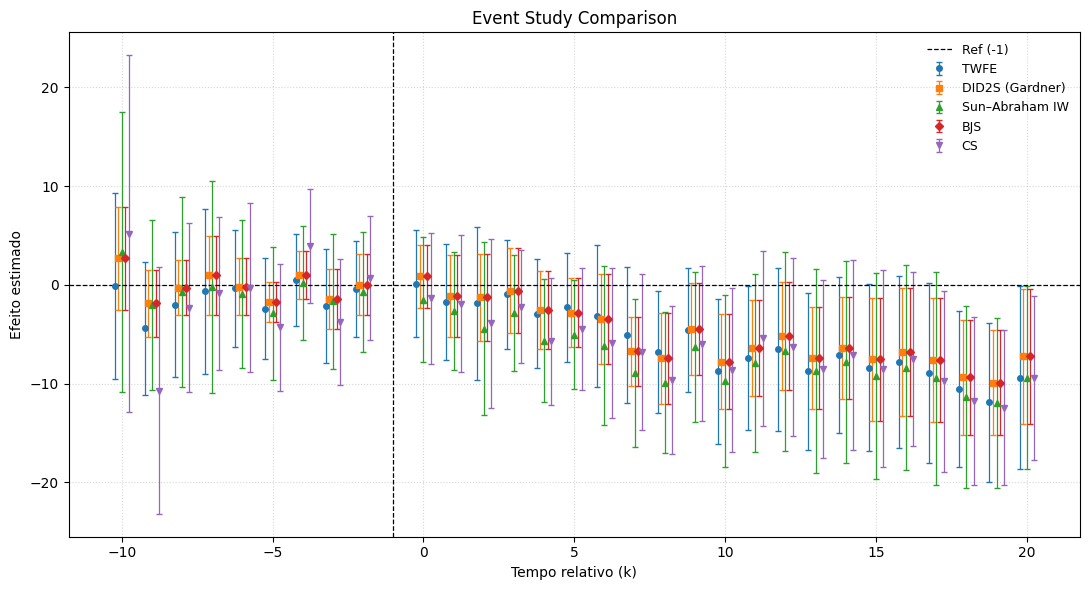

In [91]:
all_es = compare_event_studies_custom(
    series=[
        ("twfe_est",    "TWFE"),
        ("gardner_est", "DID2S (Gardner)"),
        ("sa_est",      "Sun–Abraham IW"),
        ("bjs_est",     "BJS"),
        ("cs_est",      "CS"),
    ],
    ref=-1,
    window=(-10,20),
    title="Event Study Comparison",
    dodge=0.12,
    drop_ref_for={"CS"}        # <- remove o ponto de referência só do CS
)


***de Chaisemartin & D’Haultfoeuille***

C:\Users\danie\AppData\Local\Temp\ipykernel_17204\3690910201.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = sub.groupby("id")["year"].nunique()
C:\Users\danie\AppData\Local\Temp\ipykernel_17204\3690910201.py:115: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = sub.pivot_table(index=["id","is_treated_cohort","is_control"],
C:\Users\danie\AppData\Local\Temp\ipykernel_17204\3690910201.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn


=== dC&DH (2022) — ATT pós-tratamento (k ≥ 0) ===
  Estimativa : -7.0956
  SE         :  0.7510
  IC95%      : [-8.5676, -5.6237]
  t-stat     : -9.448
  p-valor    :  0.0000

=== dC&DH (2022) — Event Study ===
    rel_year  estimate       se  ci_lower  ci_upper
0        -21  -20.1208   2.7245  -25.4607  -14.7808
1        -20  -11.4644   1.7569  -14.9080   -8.0208
2        -19    8.0076   1.9155    4.2533   11.7619
3        -18   -1.4266   1.8391   -5.0312    2.1779
4        -17   -5.0734   1.6520   -8.3112   -1.8356
5        -16   -1.2988   1.5118   -4.2619    1.6643
6        -15   -0.1496   1.3620   -2.8192    2.5199
7        -14    4.2546   1.4861    1.3419    7.1674
8        -13   -1.6282   8.7224  -18.7241   15.4676
9        -12   -0.7030  13.5098  -27.1823   25.7763
10       -11   -7.4263   7.9043  -22.9188    8.0661
11       -10    1.2274   7.0028  -12.4981   14.9529
12        -9   -2.3394   3.3044   -8.8161    4.1373
13        -8   -0.7268   4.1228   -8.8074    7.3539
14      

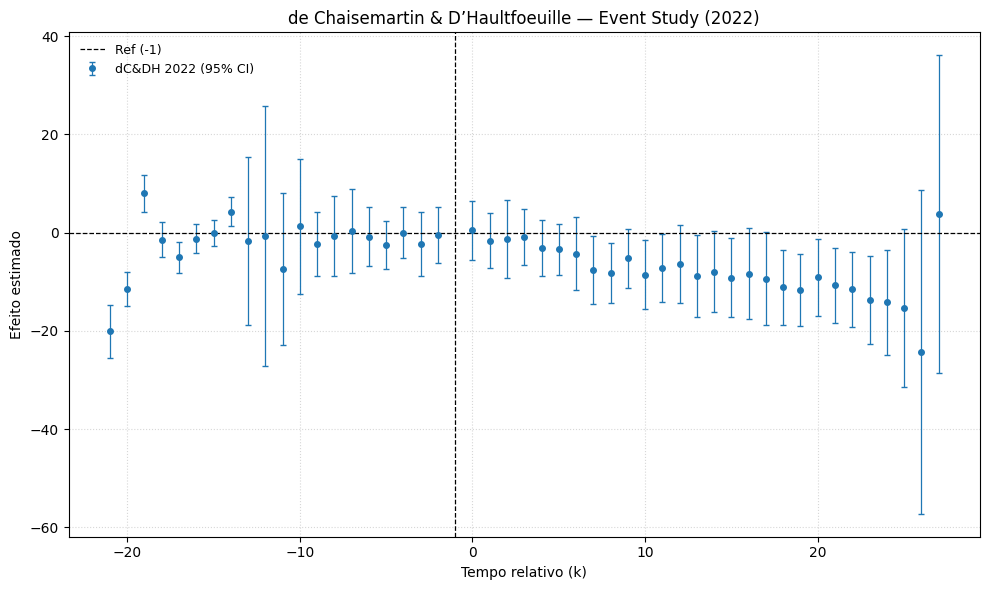

In [98]:
# ============================================================
# de Chaisemartin & D’Haultfoeuille (2020/2022) — Event Study
# Saída: dcdh_est = ['rel_year','estimate','se','ci_lower','ci_upper']
#        estatísticas do ATT pós: att_post, se_post, ci_post, t_post, p_post
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parâmetros ----------------
EST_VERSION   = "2022"     # "2020" (puro) ou "2022" (com covariáveis via residualização)
CONTROL       = "not_yet"  # "not_yet" (recomendado) ou "never"
REF           = -1         # período de referência relativo (ex.: -1)
WINDOW        = None       # ex.: (-10, 10) para limitar janela no ES (opcional)
ADD_COVS      = "+ X2"         # usado apenas se EST_VERSION == "2022", e.g. "+ X1 + X2"
SHOW_PLOT     = True
SHOW_REF_POINT= False      # se False, remove o ponto em REF do gráfico

# -------------- Inputs esperados no df --------------
# df com colunas: 'Y' (outcome), 'id' (unidade), 'year' (tempo), 'G' (coorte) ou '_nfd'

# ============================================================
# PREPARO
# ============================================================
df_d = df.copy()

for col in ["Y", "id", "year"]:
    if col not in df_d.columns:
        raise ValueError(f"Coluna obrigatória ausente: {col}")

if "G" not in df_d.columns:
    if "_nfd" in df_d.columns:
        df_d["G"] = df_d["_nfd"]
    else:
        raise ValueError("Não encontrei 'G' nem '_nfd'.")

df_d["id"]   = df_d["id"].astype("category")
df_d["year"] = pd.to_numeric(df_d["year"], errors="coerce").astype(int)
df_d["G"]    = pd.to_numeric(df_d["G"],    errors="coerce")

df_d["treated_ever"] = np.isfinite(df_d["G"]).astype(int)
df_d["rel_year"]     = np.where(df_d["treated_ever"]==1, df_d["year"] - df_d["G"], np.nan)
df_d["rel_year_int"] = pd.to_numeric(df_d["rel_year"], errors="coerce").astype("Int64")

if WINDOW is not None:
    lo, hi = WINDOW
    df_d.loc[(df_d["rel_year"] < lo) | (df_d["rel_year"] > hi), "rel_year"] = np.nan
    df_d["rel_year_int"] = pd.to_numeric(df_d["rel_year"], errors="coerce").astype("Int64")

cohorts = np.sort(df_d.loc[df_d["treated_ever"]==1, "G"].dropna().unique())

# ============================================================
# EST_VERSION == "2022": residualização com covariáveis (DID2S-like)
# ============================================================
if EST_VERSION == "2022" and ADD_COVS.strip():
    import statsmodels.formula.api as smf

    # define subconjunto de treino (controle válido)
    if CONTROL == "not_yet":
        # observações ainda não tratadas (D==0) em cada (id,year)
        df_d["_D"] = ((df_d["treated_ever"]==1) & (df_d["year"].astype(float) >= df_d["G"])).astype(int)
        sub = df_d[df_d["_D"] == 0].copy()
    elif CONTROL == "never":
        sub = df_d[df_d["treated_ever"]==0].copy()
    else:
        raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

    # primeira etapa: FE de id e ano + covariáveis, sem intercepto
    fml_stage1 = f"Y ~ C(id) + C(year) {ADD_COVS} - 1"
    fit_stage1 = smf.ols(fml_stage1, data=sub).fit()

    # prever para toda a amostra e residualizar
    df_d["_Yhat"] = fit_stage1.predict(df_d)
    df_d["_Ytilde"] = df_d["Y"] - df_d["_Yhat"]
    OUTCOME_COL = "_Ytilde"
else:
    # versão 2020 (pura, sem X) ou 2022 sem ADD_COVS fornecido
    OUTCOME_COL = "Y"

# ============================================================
# ATT(g,t) por coorte e tempo (Δ em relação ao REF)
# ============================================================
rows_gt = []
for g in cohorts:
    t_ref = g + REF
    ts_g = np.sort(df_d.loc[(df_d["treated_ever"]==1) & (df_d["G"]==g), "year"].unique())
    if t_ref not in ts_g:
        continue

    for t in ts_g:
        k = int(t - g)
        if WINDOW is not None and ((k < lo) or (k > hi)):
            continue

        sub = df_d[(df_d["year"].isin([t_ref, t]))].copy()

        if CONTROL == "not_yet":
            ctrl_mask = ((sub["treated_ever"]==0) | (sub["G"] > t))
        elif CONTROL == "never":
            ctrl_mask = (sub["treated_ever"]==0)
        else:
            raise ValueError("CONTROL deve ser 'not_yet' ou 'never'.")

        sub["is_treated_cohort"] = ((sub["treated_ever"]==1) & (sub["G"]==g)).astype(int)
        sub["is_control"]        = (ctrl_mask).astype(int)

        # manter ids que aparecem em ambos os tempos
        counts = sub.groupby("id")["year"].nunique()
        keep_ids = counts[counts==2].index
        sub = sub[sub["id"].isin(keep_ids)].copy()
        if sub.empty:
            continue

        # pivot: outcome em t_ref e t
        piv = sub.pivot_table(index=["id","is_treated_cohort","is_control"],
                              columns="year", values=OUTCOME_COL, aggfunc="mean")
        if (t_ref not in piv.columns) or (t not in piv.columns):
            continue
        piv = piv.dropna(subset=[t_ref, t], how="any").copy()
        if piv.empty:
            continue

        # ΔY por id
        dY_df = (piv[t] - piv[t_ref]).rename("dY").reset_index()

        dY_treat = dY_df.loc[dY_df["is_treated_cohort"]==1, "dY"]
        dY_ctrl  = dY_df.loc[dY_df["is_control"]==1, "dY"]

        n_t = dY_treat.shape[0]
        n_c = dY_ctrl.shape[0]
        if (n_t==0) or (n_c==0):
            continue

        att_gt = float(dY_treat.mean() - dY_ctrl.mean())

        s2_t = float(dY_treat.var(ddof=1)) if n_t>1 else 0.0
        s2_c = float(dY_ctrl.var(ddof=1))  if n_c>1 else 0.0
        var_gt = (s2_t / n_t) + (s2_c / n_c)
        se_gt  = float(np.sqrt(max(var_gt, 0.0)))

        rows_gt.append({
            "g": int(g), "t": int(t), "k": k,
            "n_treat_ids": n_t, "n_ctrl_ids": n_c,
            "estimate_gt": att_gt, "var_gt": var_gt, "se_gt": se_gt
        })

if len(rows_gt)==0:
    raise RuntimeError("Não foi possível calcular ATT(g,t). Verifique suporte amostral e REF.")

gt_df = pd.DataFrame(rows_gt)

# ============================================================
# ATT pós (k >= 0): estimativa, SE, IC95, t, p
# ============================================================
from math import sqrt
from scipy.stats import norm

post_chk = gt_df[gt_df["k"] >= 0].copy()
if post_chk.empty:
    att_post = np.nan
    se_post  = np.nan
    ci_post  = (np.nan, np.nan)
    t_post   = np.nan
    p_post   = np.nan
else:
    w_raw = post_chk["n_treat_ids"].astype(float)
    w = w_raw / w_raw.sum()
    att_post = float((w * post_chk["estimate_gt"]).sum())
    var_post = float((w**2 * post_chk["var_gt"]).sum())
    se_post  = float(sqrt(max(var_post, 0.0)))
    ci_post  = (att_post - 1.96*se_post, att_post + 1.96*se_post)
    t_post   = att_post / se_post if se_post > 0 else np.nan
    p_post   = float(2 * (1 - norm.cdf(abs(t_post))))

print(f"\n=== dC&DH ({EST_VERSION}) — ATT pós-tratamento (k ≥ 0) ===")
print(f"  Estimativa : {att_post: .4f}")
print(f"  SE         : {se_post: .4f}")
print(f"  IC95%      : [{ci_post[0]: .4f}, {ci_post[1]: .4f}]")
print(f"  t-stat     : {t_post: .3f}")
print(f"  p-valor    : {p_post: .4f}")

# ============================================================
# AGREGAÇÃO por k (event-study dinâmico)
# ============================================================
est_rows = []
for k, chk in gt_df.groupby("k"):
    w_raw = chk["n_treat_ids"].astype(float)
    if w_raw.sum() <= 0:
        continue
    w = w_raw / w_raw.sum()
    est_k = float((w * chk["estimate_gt"]).sum())
    var_k = float((w**2 * chk["var_gt"]).sum())
    se_k  = float(sqrt(max(var_k, 0.0)))
    ci_l = est_k - 1.96*se_k
    ci_u = est_k + 1.96*se_k
    est_rows.append({"rel_year": int(k), "estimate": est_k, "se": se_k,
                     "ci_lower": ci_l, "ci_upper": ci_u})

dcdh_est = pd.DataFrame(est_rows).sort_values("rel_year").reset_index(drop=True)
if not SHOW_REF_POINT:
    dcdh_est = dcdh_est[dcdh_est["rel_year"] != REF].reset_index(drop=True)

print(f"\n=== dC&DH ({EST_VERSION}) — Event Study ===")
print(dcdh_est.round(4))

# ============================================================
# GRÁFICO (opcional)
# ============================================================
if SHOW_PLOT and not dcdh_est.empty:
    plt.figure(figsize=(10,6))
    yerr = np.vstack([
        dcdh_est["estimate"] - dcdh_est["ci_lower"],
        dcdh_est["ci_upper"] - dcdh_est["estimate"]
    ])
    plt.errorbar(
        dcdh_est["rel_year"], dcdh_est["estimate"],
        yerr=yerr,
        fmt='o', markersize=4, elinewidth=0.9, capsize=2, label=f'dC&DH {EST_VERSION} (95% CI)'
    )
    plt.axhline(0, linestyle='--', linewidth=0.9, color='black')
    plt.axvline(REF, linestyle='--', linewidth=0.9, color='black', label=f"Ref ({REF})")
    plt.title(f'de Chaisemartin & D’Haultfoeuille — Event Study ({EST_VERSION})', fontsize=12)
    plt.xlabel('Tempo relativo (k)', fontsize=10)
    plt.ylabel('Efeito estimado', fontsize=10)
    plt.legend(frameon=False, fontsize=9)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------
# Saídas úteis:
#   - dcdh_est: DataFrame ['rel_year','estimate','se','ci_lower','ci_upper']
#   - gt_df:    ATT(g,t) granular por coorte/tempo (com variâncias)
#   - att_post, se_post, ci_post, t_post, p_post: resumo pós-tratamento
# ------------------------


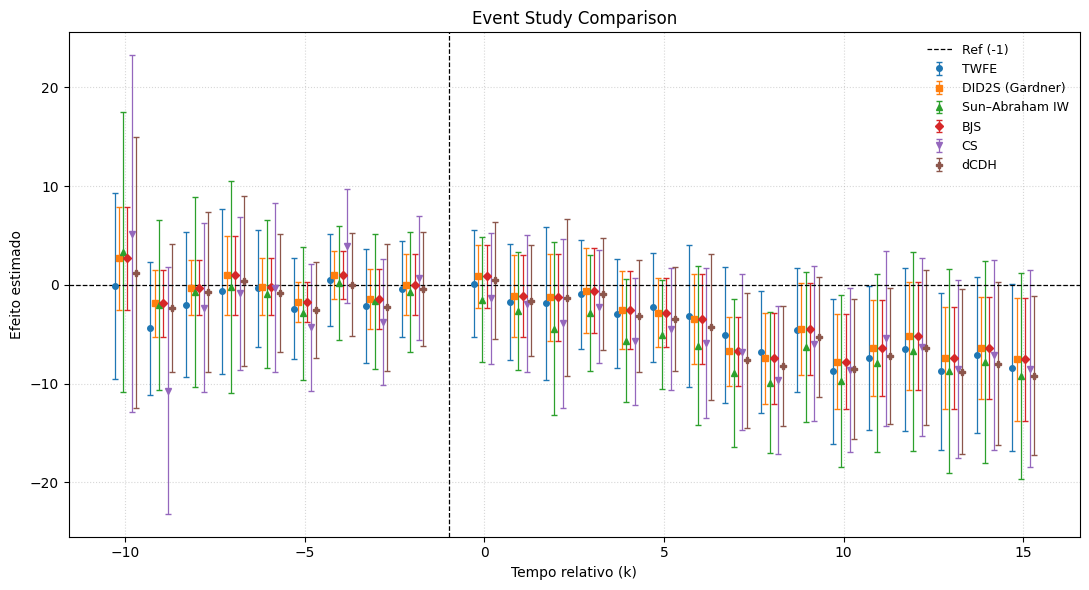

In [100]:
all_es = compare_event_studies_custom(
    series=[
        ("twfe_est",    "TWFE"),
        ("gardner_est", "DID2S (Gardner)"),
        ("sa_est",      "Sun–Abraham IW"),
        ("bjs_est",     "BJS"),
        ("cs_est",      "CS"),
        ("dcdh_est",      "dCDH"),
    ],
    ref=-1,
    window=(-10,15),
    title="Event Study Comparison",
    dodge=0.12,
    drop_ref_for={"CS"}        # <- remove o ponto de referência só do CS
)